In [1]:
import re
import os

In [2]:
def parse_cases(log_filename):
    """
    Parse a log file and return two lists of dicts:
      - q_cases: [{'case': 'Q20',  'nodes': 441,    'dat': 'dcs042-420200.dat'}, …]
      - t_cases: [{'case': 'T20',  'nodes': 510,    'dat': 'dcs042-420210.dat'}, …]
    """
    # regex to grab each block from "Running Q20" up to (but not including) the next "Running …" or EOF
    block_re = re.compile(r"Running\s+([QT]\d+)([\s\S]*?)(?=^Running\s+[QT]\d+|\Z)", re.MULTILINE)
    # within each block:
    nodes_re = re.compile(r"Mesh loaded.*?with \d+ elements and (\d+) nodes")
    dat_re   = re.compile(r"Kernel timing written to .*/([^/]+\.dat)")

    q_cases = []
    t_cases = []

    with open(log_filename, 'r') as f:
        content = f.read()

    for case_id, block in block_re.findall(content):
        # extract nodes
        m_nodes = nodes_re.search(block)
        nodes   = int(m_nodes.group(1)) if m_nodes else None

        # extract dat filename (no path)
        m_dat   = dat_re.search(block)
        datfile = m_dat.group(1) if m_dat else None

        record = {'case': case_id, 'nodes': nodes, 'dat': datfile}
        if case_id.startswith('Q'):
            q_cases.append(record)
        else:
            t_cases.append(record)

    return q_cases, t_cases


In [3]:
gpu_q_list, gpu_t_list = parse_cases(r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\gpu_cases\gpu.out')
omp_q_list, omp_t_list = parse_cases(r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\omp_cases\omp.out')
serial_q_list, serial_t_list = parse_cases(r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\serial_cases\serial.out')


In [4]:
def parse_region_times(out_filename):
    """
    Given a filename like 'dcs042-420200.dat.out', parse and return a dict:
      { 'Create CSR Row Index': 0.000952,
        'Compute Element Stiffness Matrix and Load Vector': 0.000597,
        … }
    """
    region_re = re.compile(r"^- (.+)$")         # capture the region description
    time_re   = re.compile(r"\(REGION\)\s+([\d.]+)")  # capture the first number

    times = {}
    with open(out_filename, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        m_reg = region_re.match(lines[i].strip())
        if m_reg and i + 1 < len(lines):
            region = m_reg.group(1).strip()
            # look on the very next line for the time
            m_time = time_re.search(lines[i+1])
            if m_time:
                times[region] = float(m_time.group(1))
            i += 2
        else:
            i += 1

    return times

def collect_all_times(case_lists, base_dir):
    """
    case_lists: list of dicts [{'case': 'Q20', 'nodes': 441, 'dat': 'dcs042-420200.dat'}, …]
    base_dir:   path where the .dat.out files live
    Returns:    a dict mapping case -> { region: time, … }
    """
    all_data = {}
    for rec in case_lists:
        datfile = rec['dat']
        if not datfile:
            continue
        out_name = datfile + '.out'
        fullpath = os.path.join(base_dir, out_name)
        if os.path.isfile(fullpath):
            all_data[rec['case']] = parse_region_times(fullpath)
        else:
            all_data[rec['case']] = None  # or {}
    return all_data

In [5]:
# set the directories for each backend’s .out files:
gpu_dir    = r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\gpu_cases'
omp_dir    = r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\omp_cases'
serial_dir = r'D:\Codes\miscPyScripts\CAS-Assignment2\cases\serial_cases'

# collect times
gpu_q_times     = collect_all_times(gpu_q_list, gpu_dir)
gpu_t_times     = collect_all_times(gpu_t_list, gpu_dir)
omp_q_times     = collect_all_times(omp_q_list, omp_dir)
omp_t_times     = collect_all_times(omp_t_list, omp_dir)
serial_q_times  = collect_all_times(serial_q_list, serial_dir)
serial_t_times  = collect_all_times(serial_t_list, serial_dir)

In [6]:
# Here's a sample of how to access the data:
gpu_q_times

{'Q20': {'Create CSR Row Index': 0.000952,
  'Compute Element Stiffness Matrix and Load Vector': 0.000597,
  'Allocate CSR': 0.00013,
  'Allocate Element Stiffness Matrix and Load Vector': 0.000126,
  'Sort Element Stiffness Matrix': 0.000125,
  'Assemble Load Vector': 8.6e-05,
  'Fill Stiffness CSR': 4.4e-05},
 'Q100': {'Create CSR Row Index': 0.001042,
  'Sort Element Stiffness Matrix': 0.000854,
  'Compute Element Stiffness Matrix and Load Vector': 0.000573,
  'Allocate Element Stiffness Matrix and Load Vector': 0.000445,
  'Allocate CSR': 0.000134,
  'Assemble Load Vector': 9e-05,
  'Fill Stiffness CSR': 5.2e-05},
 'Q500': {'Sort Element Stiffness Matrix': 0.005045,
  'Create CSR Row Index': 0.00218,
  'Fill Stiffness CSR': 0.002138,
  'Allocate Element Stiffness Matrix and Load Vector': 0.00155,
  'Allocate CSR': 0.001335,
  'Compute Element Stiffness Matrix and Load Vector': 0.000961,
  'Assemble Load Vector': 0.000445},
 'Q1000': {'Sort Element Stiffness Matrix': 0.018831,
  'Fi

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def get_times(case_list, times_dict):
    compute_regs = [
        'Compute Element Stiffness Matrix and Load Vector',
        'Allocate Element Stiffness Matrix and Load Vector'
    ]
    assembly_regs = [
        'Sort Element Stiffness Matrix',
        'Fill Stiffness CSR',
        'Create CSR Row Index',
        'Allocate CSR',
        'Assemble Load Vector'
    ]

    sorted_recs = sorted(case_list, key=lambda r: r['nodes'])
    nodes, comp, asm = [], [], []
    for rec in sorted_recs:
        cid = rec['case']
        n   = rec['nodes']
        times = times_dict.get(cid, {})
        t_compute  = sum(times.get(r, 0.0) for r in compute_regs)
        t_assembly = sum(times.get(r, 0.0) for r in assembly_regs)
        nodes.append(n); comp.append(t_compute); asm.append(t_assembly)
    return np.array(nodes), np.array(comp), np.array(asm)

# color map per backend
colors = {
    'GPU':    'green',
    'OpenMP': 'blue',
    'Serial': 'red'
}

backends = {
    'GPU':    (gpu_q_list,    gpu_q_times),
    'OpenMP': (omp_q_list,    omp_q_times),
    'Serial': (serial_q_list, serial_q_times)
}

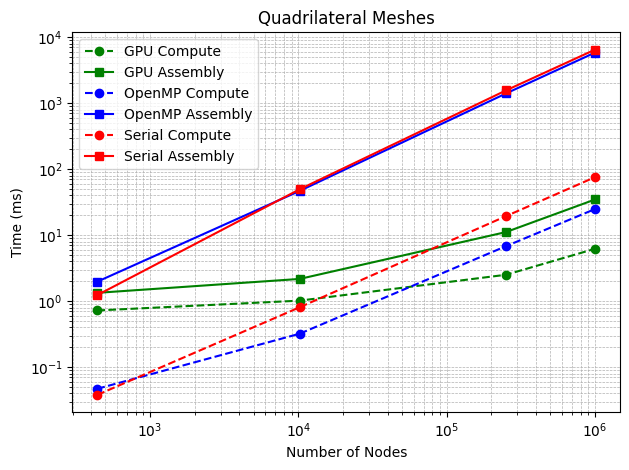

In [9]:
plt.figure()
for label, (clist, tdict) in backends.items():
    x, y_comp, y_asm = get_times(clist, tdict)
    c = colors[label]
    # compute: dashed
    plt.plot(x, y_comp*1000, linestyle='--', marker='o', color=c, label=f"{label} Compute")
    # assembly: solid
    plt.plot(x, y_asm*1000,  linestyle='-',  marker='s', color=c, label=f"{label} Assembly")

plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.title("Quadrilateral Meshes")
plt.tight_layout()
plt.show()

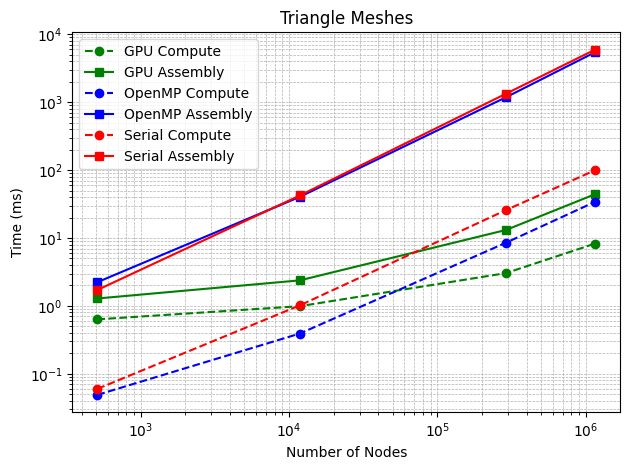

In [10]:
# Map each backend to its triangle case lists & times
backends_tri = {
    'GPU':    (gpu_t_list,    gpu_t_times),
    'OpenMP': (omp_t_list,    omp_t_times),
    'Serial': (serial_t_list, serial_t_times)
}

plt.figure()
for label, (clist, tdict) in backends_tri.items():
    x, y_comp, y_asm = get_times(clist, tdict)
    c = colors[label]
    # Compute (dashed)
    plt.plot(x, y_comp*1000,
             linestyle='--', marker='o',
             color=c, label=f"{label} Compute")
    # Assembly (solid)
    plt.plot(x, y_asm*1000,
             linestyle='-', marker='s',
             color=c, label=f"{label} Assembly")

plt.xlabel("Number of Nodes")
plt.ylabel("Time (ms)")
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.title("Triangle Meshes")
plt.tight_layout()
plt.show()


Even though we used Kokkos ScatterView for OpenMP, the OpenMP performance did not improve from serial.

$$
\text{speedup}_\text{GPU} = \frac{t_\text{serial}}{t_\text{gpu}},\quad
\text{speedup}_\text{OMP} = \frac{t_\text{serial}}{t_\text{omp}}
$$

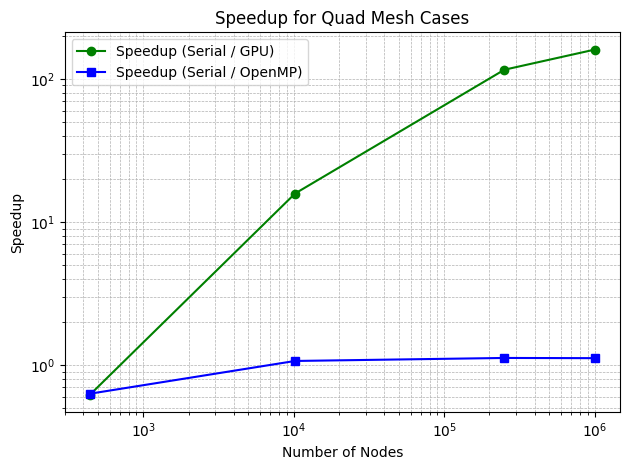

In [11]:
x, gpu_comp, gpu_asm      = get_times(gpu_q_list,    gpu_q_times)
_, omp_comp, omp_asm      = get_times(omp_q_list,    omp_q_times)
_, ser_comp, ser_asm      = get_times(serial_q_list, serial_q_times)
q_gpu = gpu_comp + gpu_asm
q_omp = omp_comp + omp_asm
q_serial = ser_comp + ser_asm

# Compute speedups
speedup_gpu = q_serial / q_gpu
speedup_omp = q_serial / q_omp

# Plot
plt.figure()
plt.plot(x, speedup_gpu,
         linestyle='-', marker='o',
         color='green', label='Speedup (Serial / GPU)')
plt.plot(x, speedup_omp,
         linestyle='-', marker='s',
         color='blue',  label='Speedup (Serial / OpenMP)')

plt.xlabel('Number of Nodes')
plt.ylabel('Speedup')
plt.xscale('log')
plt.yscale('log')
plt.title('Speedup for Quad Mesh Cases')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

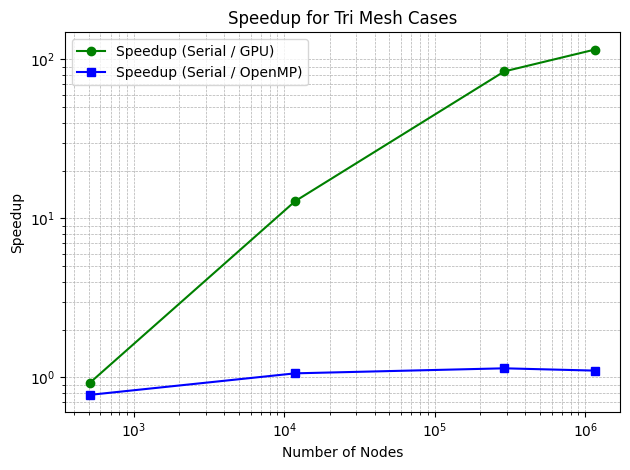

In [12]:
x, gpu_comp, gpu_asm      = get_times(gpu_t_list,    gpu_t_times)
_, omp_comp, omp_asm      = get_times(omp_t_list,    omp_t_times)
_, ser_comp, ser_asm      = get_times(serial_t_list, serial_t_times)
t_gpu = gpu_comp + gpu_asm
t_omp = omp_comp + omp_asm
t_serial = ser_comp + ser_asm

# Compute speedups
speedup_gpu = t_serial / t_gpu
speedup_omp = t_serial / t_omp

# Plot
plt.figure()
plt.plot(x, speedup_gpu,
         linestyle='-', marker='o',
         color='green', label='Speedup (Serial / GPU)')
plt.plot(x, speedup_omp,
         linestyle='-', marker='s',
         color='blue',  label='Speedup (Serial / OpenMP)')

plt.xlabel('Number of Nodes')
plt.ylabel('Speedup')
plt.xscale('log')
plt.yscale('log')
plt.title('Speedup for Tri Mesh Cases')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()